# Stree view house number

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
from fastai.plots import *
import pandas as pd
from fastai.conv_learner import *
from fastai.dataset import *

In [39]:
ls /fast/data/SVHN

extra/            models/          test.tar.gz      train_length.csv
extra_boxes.csv   test/            tmp/             train.tar.gz
extra.csv         test_boxes.csv   train/
extra_length.csv  test.csv         train_boxes.csv
extra.tar.gz      test_length.csv  train.csv


In [40]:
home_dir = '/fast/data/SVHN/'

In [41]:
train_df = pd.read_csv(os.path.join(home_dir, 'extra.csv'))

In [42]:
max([len(l.split(' ')) for l in list(train_df.tags)])

5

In [43]:
train_df.sample(3)

,image_name,tags
99722,189749,1 4 9
85802,17722,2 10
112280,201049,1 4 8 3


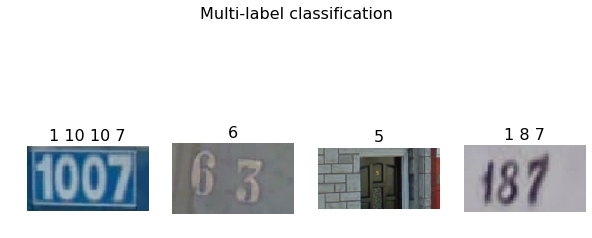

In [44]:
samples = train_df.sample(4)
list_paths = [f"{home_dir}extra/{i}.png" for i in list(samples['image_name'])]
titles=list(samples['tags'])
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [45]:
f_model = resnet34

In [46]:
label_csv = os.path.join(home_dir, 'extra.csv')
bb_csv = os.path.join(home_dir, 'extra_boxes.csv')
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [47]:
train_df = pd.read_csv(label_csv)
train_df['tags'] = train_df.tags.apply(lambda x: [int(i) if int(i) != 10 else 0 for i in x.split(' ')])

In [48]:
((val_label,trn_label),) = split_by_idx(val_idxs, train_df)

In [49]:
def get_data(sz, bs=30):
    aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD), 
                RandomStretch(max_stretch=0.5, tfm_y=TfmType.COORD),
               ]
    tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
    return ImageClassifierData.from_csv(home_dir, 'extra', bb_csv, tfms=tfms, bs=bs, 
                                        suffix='.png', val_idxs=val_idxs, test_name='test',
                                        continuous=True, num_workers=4)

In [50]:
sz = 64
data = get_data(64)

In [51]:
x, y = data.trn_ds[0]

In [52]:
x.shape, y

((3, 64, 64),
 array([31.,  4., 53., 19., 19., 19., 40., 33., 11., 30., 32., 50.], dtype=float32))

In [53]:
y

array([31.,  4., 53., 19., 19., 19., 40., 33., 11., 30., 32., 50.], dtype=float32)

In [54]:
from matplotlib import patches, patheffects
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def get_big_bounding_box(boxes):
    # top, left, bottom, right
    return np.array([min(boxes[:, 0]), min(boxes[:,1]), max(boxes[:, 2]), max(boxes[:, 3])])

def draw_im(im, boxes, cats, draw_one_box=False):
    ax = show_img(im, figsize=(8,4))
    if draw_one_box:
        b = bb_hw(boxes)
        draw_rect(ax, b)
    else:
        for b, c in zip(boxes, cats):
            b = bb_hw(b)
            draw_rect(ax, b)
            draw_text(ax, b[:2], c, sz=16)

In [55]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, labels, sz):
        self.ds,self.labels = ds,labels
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        boxes = y.reshape((-1, 4))
        box = get_big_bounding_box(boxes) / sz
        return (x, ((len(self.labels[i])-1), box, np.array(self.labels[i])))
#         return (x, (y, np.array(self.labels[i]), len(self.labels[i])-1))

In [56]:
len(trn_label), len(val_label)

(161883, 40470)

In [57]:
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [58]:
x, y = data.trn_ds[4]
print(x.shape, y)

(3, 64, 64) (2, array([0.25   , 0.29688, 0.64062, 0.65625], dtype=float32), array([1, 5, 2]))


(1, array([0.25   , 0.32812, 0.71875, 0.64062], dtype=float32), array([7, 5]))


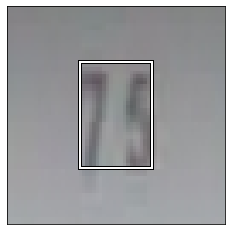

In [59]:
x, y = data.trn_ds[117]
img = data.val_ds.ds.denorm(to_np(x))[0]
boxes = y[1] * sz
draw_im(img, boxes, y[1], draw_one_box=True)
print(y)

In [60]:
class CountHead(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.adaptive = AdaptiveConcatPool2d((2,2))
        self.flatten = Flatten()
        self.layer1 = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(n, 1024), nn.BatchNorm1d(1024), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU())
        self.layer31 = nn.Sequential(nn.Linear(512, 6))
        self.layer32 = nn.Sequential(nn.Linear(512, 4), nn.Sigmoid())
        self.layer33 = nn.Linear(512, 10 * 6)
    def forward(self, x):
        out = self.adaptive(x)
        out = self.flatten(out)
        out = self.layer1(out)
        out = self.layer2(out)
        label = self.layer31(out)
        box = self.layer32(out)
        nums = self.layer33(out).reshape(-1, 6, 10)
        return [label, box, nums]

In [61]:
def custome_accuracy(input:list, targs:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    input = input[0]
    targs = targs[0]
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [62]:
def custome_accuracy_with_confidence_90(input:list, targs:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    THREADHOLD = 0.9
    input = input[0]
    targs = targs[0]
    max_v, n_nums = nn.Softmax()(input).max(dim=1)
    mark = max_v > THREADHOLD
    return (n_nums[mark] == targs[mark]).float().sum() / mark.float().sum()

In [63]:
def custome_accuracy_with_confidence_95(input:list, targs:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    THREADHOLD = 0.95
    input = input[0]
    targs = targs[0]
    max_v, n_nums = nn.Softmax()(input).max(dim=1)
    mark = max_v > THREADHOLD
    return (n_nums[mark] == targs[mark]).float().sum() / mark.float().sum()

In [64]:
def num_accuracy(pred:list, labels:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n_sample = 0.0
    true_case = 0.0
    n_nums = pred[0].argmax(dim=1) + 1
    batch_size = pred[N_NUMBER_INDEX].shape[0]
    for i in range(batch_size):
        n_sample += 1
        pred_num = int(''.join([str(j.item()) for j in pred[NUMBER_INDEX][i][-n_nums[i]:].argmax(dim=1)]))
        true_num = int(''.join([str(j.item()) for j in labels[NUMBER_INDEX][i]]))
        if pred_num == true_num:
            true_case += 1
    return true_case / n_sample

In [65]:
count_head = CountHead(1024*4)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=count_head)
learn = ConvLearner(data, models, metrics=[custome_accuracy, 
                                           custome_accuracy_with_confidence_90,
                                           custome_accuracy_with_confidence_95,
                                           num_accuracy])
learn.opt_fn = optim.Adam

In [66]:
# count_head

In [67]:
NUMBER_INDEX = 2
N_NUMBER_INDEX= 0

In [68]:
class MSECustomize(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss()
        self.num_loss = nn.CrossEntropyLoss()
        self.box_loss = nn.L1Loss()
    def forward(self, pred, targ):
        batch_size = pred[N_NUMBER_INDEX].shape[0]
        num_loss = sum([self.num_loss(pred[NUMBER_INDEX][i][-(targ[N_NUMBER_INDEX][i] + 1):], targ[NUMBER_INDEX][i][-(targ[N_NUMBER_INDEX][i] + 1):]) for i in range(batch_size)])/ batch_size
        return 2 * num_loss + self.loss(pred[0], targ[0]) + 10 * self.box_loss(pred[1], targ[1]) 

In [69]:
learn.crit = MSECustomize()

In [70]:
# learn.summary()

In [71]:
lr = 3e-4

In [73]:
# you can train model at the beginning or load saved model at tutorial 004
learn.load('svhn_number_005_pool2')

In [74]:
sz = 256
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [75]:
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      1.261959   0.910633   0.940425   0.987893   0.992329   0.852656  
    1      1.087211   0.866533   0.945935   0.988945   0.993246   0.865777  
    2      1.043842   0.828967   0.946825   0.987716   0.992251   0.870052  



[0.8289673794102368,
 0.946824845735721,
 0.9877164936489843,
 0.9922513656478356,
 0.870051890289103]

In [78]:
lrs = [lr/100, lr/10, lr]
learn.freeze_to(-2)
learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      0.773046   0.661043   0.960934   0.993621   0.996044   0.913664  
    1      0.678738   0.625059   0.963356   0.992339   0.995228   0.923993  
    2      0.794553   0.591621   0.964962   0.993732   0.995686   0.927971  



[0.5916206455389776,
 0.9649617284028242,
 0.9937321290075558,
 0.9956863515460112,
 0.927971336792686]

In [79]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('svhn_number_003_num_extra')

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      0.604409   0.584442   0.96595    0.993135   0.995357   0.929479  
    1      0.633066   0.596846   0.963677   0.992531   0.995169   0.927082  
    2      0.528218   0.60288    0.965283   0.992739   0.99513    0.932963  
    3      0.585912   0.621418   0.963702   0.991025   0.993296   0.928713  
    4      0.490569   0.589184   0.966815   0.990911   0.993282   0.935631  
    5      0.487589   0.594549   0.967111   0.990637   0.992947   0.938498  
    6      0.390967   0.591422   0.96721    0.990502   0.993139   0.939239  



In [80]:
learn.load('svhn_number_003_num_extra')

In [81]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('svhn_number_004_num_extra')

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      0.404964   0.597736   0.967408   0.990355   0.992841   0.939906  
    1      0.522932   0.636621   0.966148   0.988614   0.991247   0.935705  
    2      0.38709    0.608203   0.967334   0.989927   0.992503   0.939758  
    3      0.469549   0.64849    0.96254    0.989428   0.992226   0.928317  
    4      0.435413   0.657209   0.9596     0.988744   0.992246   0.92765   
    5      0.387257   0.643288   0.966173   0.987763   0.990758   0.938028  
    6      0.415455   0.66599    0.967062   0.985143   0.987724   0.941438  



In [ ]:
learn.unfreeze()
learn.fit(lrs, 6, cycle_len=1, cycle_mult=2)
learn.save('svhn_number_005_num_extra')

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      0.395234   0.655515   0.967408   0.986254   0.989224   0.939634  
    1      0.41129    0.667214   0.964789   0.987195   0.989878   0.935236  
    2      0.436597   0.671974   0.967359   0.985409   0.988407   0.940227  
    3      0.401666   0.660657   0.963034   0.987879   0.990616   0.930072  
    4      0.362795   0.69172    0.96385    0.985505   0.988866   0.93316   
    5      0.432862   0.701217   0.965184   0.98364    0.986761   0.938325  
    6      0.298527   0.689744   0.966      0.983632   0.987169   0.940153  
    7      0.401261   0.699029   0.958982   0.984654   0.988602   0.926934  
    8      0.400707   0.699968   0.963553   0.983828   0.987329   0.934791  
    9      0.421203   0.709872   0.96469    0.983014   0.986628   0.937312  
    10     0.330015   0.723739   0.965332   0.98215    0.985111   0.939708  
    11     0.3091

In [ ]:
ls /fast/data/SVHN/models